<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Целевой-признак" data-toc-modified-id="Целевой-признак-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Целевой признак</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Распределение" data-toc-modified-id="Распределение-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Распределение</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li></ul></li><li><span><a href="#Обучение-и-тестирование" data-toc-modified-id="Обучение-и-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дамми-модель" data-toc-modified-id="Дамми-модель-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дамми модель</a></span></li><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Предобработка данных

In [1]:
RAND=42

In [39]:
import warnings
warnings.filterwarnings('ignore')
#import sys
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import model_selection, tree, linear_model, metrics, ensemble, preprocessing, neighbors, compose, naive_bayes, svm, set_config, impute, manifold, feature_selection, inspection, pipeline, decomposition
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
import xgboost as xgb
#import phik
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
#import category_encoders
#import optuna
import catboost as cat
from catboost import Pool, cv
#optuna.logging.set_verbosity(optuna.logging.INFO)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
import time
import copy
import gc
import requests
from tqdm import tqdm
import urllib.request
import zipfile, io
#import torch
#import torch.nn as nn
#import torch.optim as optim
#from torch.utils.data.sampler import SubsetRandomSampler, Sampler, SequentialSampler
import regex as re
from typing import Union, Any

project_start = time.time()

In [3]:
%matplotlib inline
set_config(display="diagram")
xgb.set_config(verbosity=0)
sns.set()
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_palette('pastel')
plt.rcParams["figure.figsize"] = (12, 8)

In [4]:
random_state = 2077
max_iter = 10000
np.random.seed(seed=random_state)
#torch.manual_seed(random_state)

### Загрузка данных

In [5]:
file_path = '...'

def load_dataframe(filename, file_path, showinfo=True, showdescribe=False, showcolumns=True, **kwargs):
    try:
        df = pd.read_csv('/datasets/' + filename, **kwargs, sep=',')  # Серверный путь
        print('Загружено с сервера')
    except:
        try:
            df = pd.read_csv(file_path + filename, **kwargs, sep=',')  # Локальный путь
            print('Загружено с локального диска')
        except:
            try:
                df = pd.read_csv('/content/' + filename, **kwargs, sep=',')  # Путь гугл-диска
                print('Загружено с гугл-диска')
            except: print('Файл не найден')
                
    df.columns = [i.lower().strip().replace(' ','') for i in df.columns]

    print('Количество дубликатов', df.duplicated().sum())
    print('Количество пропусков всего', df.isna().sum(axis=1).sum(axis=0))
    a = df.isna().sum()
    print('Количество столбцов с пропусками', len(a[a>0]))
    print()

    if showinfo:
        display(df.info())
    if showdescribe:
        display(df.describe(include='all').T)
    if showcolumns:
        print(df.columns.tolist())
    return df

Сделаем колонку с датой индексной и преобразуем в datetime:

In [6]:
df = load_dataframe(filename ='taxi.csv', file_path=file_path, index_col=[0], parse_dates=[0])

Загружено с сервера
Количество дубликатов 26415
Количество пропусков всего 0
Количество столбцов с пропусками 0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

['num_orders']


Пропусков в данных нет.

**Ресемплируем данные по 1 часу:**

In [7]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные лежат с марта по август 2018 года.

Хоть и памяти датасет занимает немного, всё же оптимизируем её использование:

In [9]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols): #Отображение движущегося изображения tqdm
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = check_if_integer(df[col])

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [10]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 0.07 MB


100%|██████████| 1/1 [00:00<00:00, 614.82it/s]

Memory usage after optimization is: 0.042 MB
Decreased by 37.5%


### Целевой признак

До того, как делать выборки, посмотрим на целевой признак внимательно.

У нас метрика RMSE, очень чувствительная к выбросам. Поэтому наличие таких выбросов  будет стабильно снижать результирующую метрику модели. Подбор гиперпараметров при этом будет проводиться не для улучшения реального качества модели, а для подгона ее под выбросы.

Поэтому нам необходимо решить проблему выбросов сразу и жестко.

Посмотрим на распределение целевого признака.

In [11]:
df.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99, .999]).round(2).T

,count,mean,std,min,25%,50%,75%,90%,99%,99.9%,max
num_orders,4416.0,84.42,45.02,0.0,54.0,78.0,107.0,143.0,223.0,289.19,462.0


Можно сразу откинуть данные после 99.9 персентиля, так как отличие довольно большое.

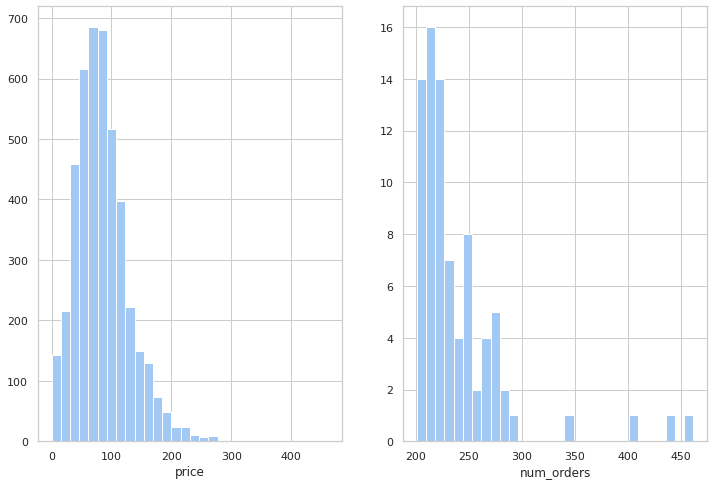

In [12]:
n = df['num_orders']
plt.subplot(1,2,1)
n.hist(bins=30)
plt.xlabel('price')
plt.subplot(1,2,2)
n[n > 200].hist(bins=30)
plt.xlabel('num_orders');

На распределении также прекрасно видны выбросы, которые сильно могут попортить метрику.


In [19]:
pd.concat(
    [df[df['num_orders'] > 289], pd.DataFrame({'dayofweek': df[df['num_orders'] > 289].index.dayofweek}, index=df[df['num_orders'] > 289].index)]
    , axis=1
)

,num_orders,dayofweek
datetime,,
2018-08-13 02:00:00,437,0
2018-08-20 02:00:00,462,0
2018-08-27 02:00:00,408,0
2018-08-27 04:00:00,295,0
2018-08-30 17:00:00,342,3


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Проанализировав выбросы понял, что основная их часть падает на 2 часа ночи понедельника. Видимо, люди возвращаются домой после отдыха.  
Оставим данные на базе</div>

## Анализ

### Распределение

Посмотрим на скользящее среднее и стандартное отклонение с окном в 24 часа:

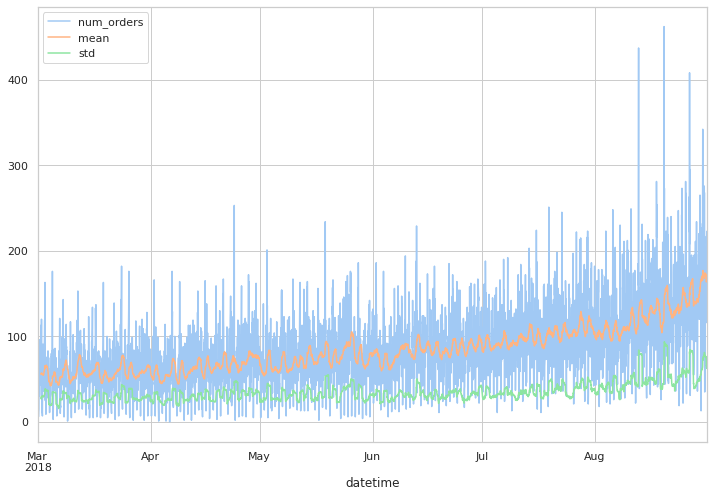

In [20]:
data = pd.DataFrame()
data['num_orders'] = df['num_orders'].copy()
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
data.plot();

Видно, что среднее значение с течением времени растет, дисперсия примерно одинакова. Распределение нестационарное, но близкое к стационарному.

Виден общий растущий тренд, исследуем сезонность.

### Тренды и сезонность

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int16
dtypes: int16(1)
memory usage: 172.2 KB


Декомпозируем следующими способами:

1. Разделим датафрейм на 8 групп (чтобы более явно увидеть тренд), пользуясь параметром `period`:

In [22]:
decomposed = seasonal_decompose(df, period=int(len(df)/8))

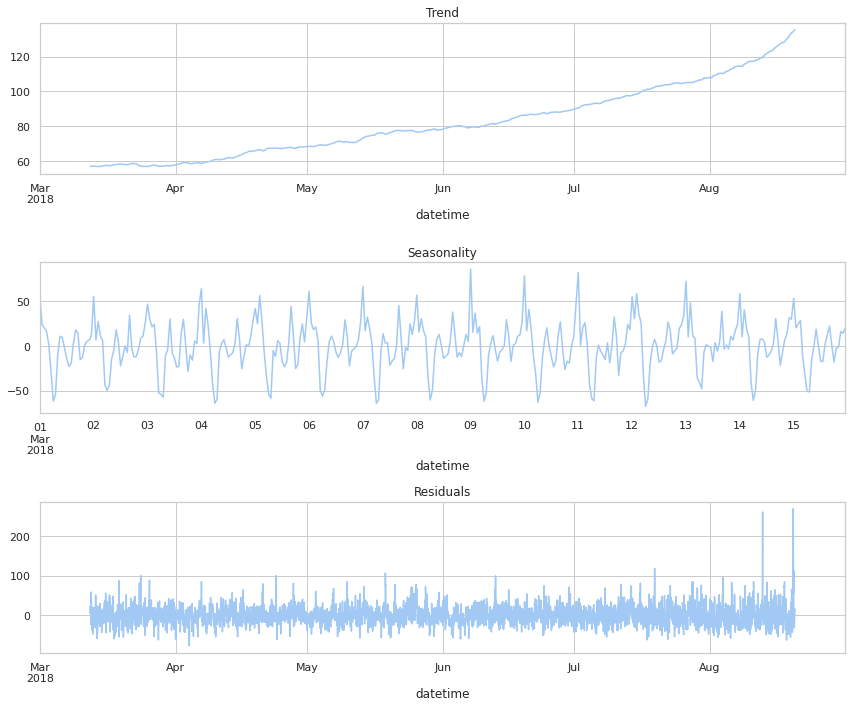

In [23]:
plt.figure(figsize=(12, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Виден общий тренд на увеличение количества заказов, с марта по август суточная норма увеличилась более, чем в 2 раза. Также по дням видна сезонность, есть общие экстремумы примерно в равное время.

Посмотрим на сезонность поближе (какая в течение дня):

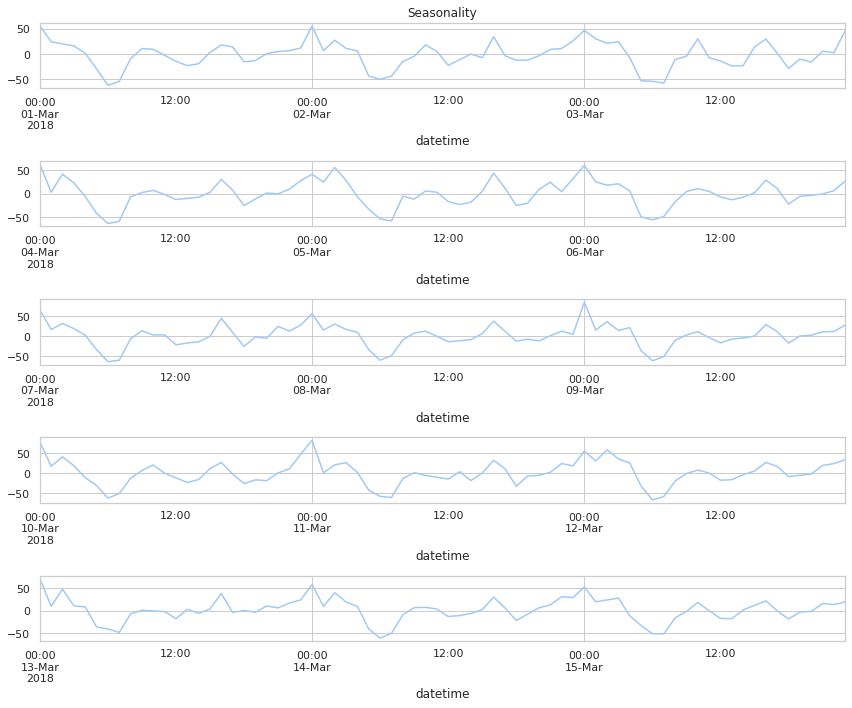

In [24]:
plt.figure(figsize=(12, 10))
plt.subplot(511)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(512)
decomposed.seasonal['2018-03-04':'2018-03-06'].plot(ax=plt.gca())
plt.subplot(513)
decomposed.seasonal['2018-03-07':'2018-03-09'].plot(ax=plt.gca())
plt.subplot(514)
decomposed.seasonal['2018-03-10':'2018-03-12'].plot(ax=plt.gca())
plt.subplot(515)
decomposed.seasonal['2018-03-13':'2018-03-15'].plot(ax=plt.gca())

plt.tight_layout()

Видно, что каждый день в 12 часов дня заказов наименьшее количество, а наибольшее в 6-7 часов утра.

2. Попробуем стандартным образом использовать декомпозицию данных за каждый час:

In [26]:
decomposed2 = seasonal_decompose(df)

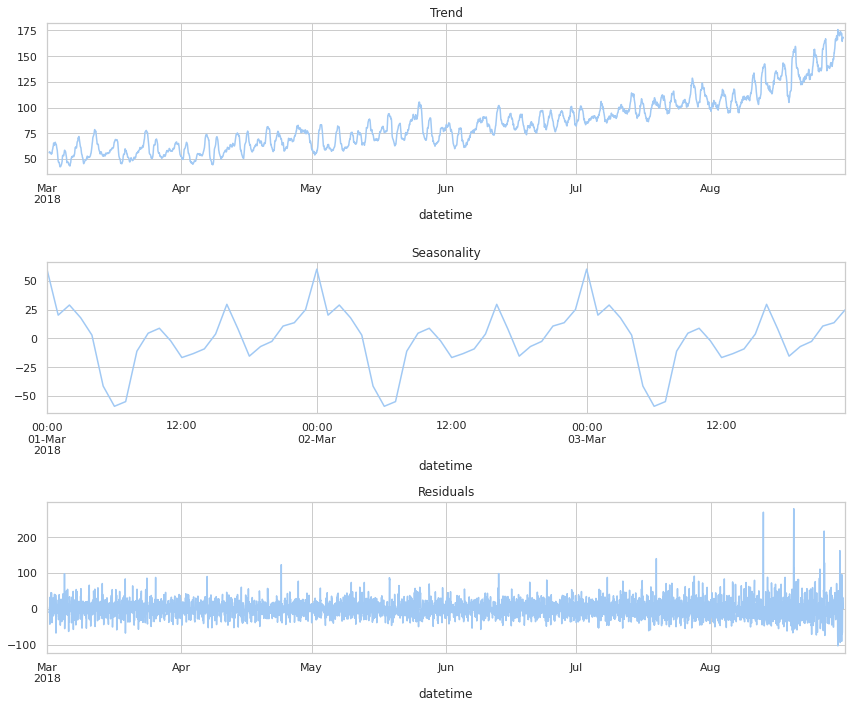

In [27]:
plt.figure(figsize=(12, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis)
decomposed2.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed2.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed2.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Результаты второго способа несколько противоречат результатам первого. Хоть все еще прослеживается локальный минимум у 12ти часов дня, пик заказов в период 6-7 часов превратился в дефицит заказов.  
А большую часть заказов делают в полночь.


## Обучение и тестирование

### Линейная регрессия

In [28]:
def make_features(data, max_lag, rolling_mean_size):
    '''
    1. Календарные признаки
    2. «Отстающие значения». Предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться.
    3. Скользящее среднее как признак задаёт общий тренд временного ряда. Скользящее среднее в моменте t учитывает текущее значение ряда x(t). 
    Это некорректно: целевой признак «убежал» в признаки. Поэтому сдвигаем среднее на 1 объект вниз.
    '''
    
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

По исходным данным создадим обучающую (train) и тестовую (test) выборки. Перемешивать выборки в задаче прогнозирования временного ряда нельзя (shuffle=False). Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего.

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Размер окна ставим 24 часа, легче интерпретируется.</div>

In [55]:
make_features(df, 1, 24)

train, test = model_selection.train_test_split(df, shuffle=False, test_size=0.2) #не перемешиваем, так как время должно идти по порядку
train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

model = LinearRegression()
model.fit(train_features, train_target)

print("RMSE обучающей выборки:", mse(model.predict(train_features), train_target, squared=False))
print("RMSE тестовой выборки: ", mse(model.predict(test_features), test_target, squared=False))

RMSE обучающей выборки: 29.331039934766345
RMSE тестовой выборки:  46.68456068264935


### Дамми модель

Проверка на адекватность:  
Сравним результат с прогнозом без обучения: новое значение ряда x(t) будем прогнозировать значением x(t-1):

In [32]:
print("Средний объем заказов такси в час:", test['num_orders'].mean())

pred_previous = test.shift(1, fill_value=train.iloc[-1, 0])
print("RMSE:", mse(pred_previous, test, squared=False))

Средний объем заказов такси в час: 124.83823529411765
RMSE: 25.396883089893432


Результат вышел даже лучше, чем у регрессии  
Попробуем предсказание средним:

In [33]:
pred_mean =  np.ones(test.shape) * train['num_orders'].mean()
print("RMSE:", mse(test, pred_mean, squared=False))

RMSE: 66.86592084292705


Тут все плохо, данные сильно колеблются, из-за этого ошибка на каждом шаге сильно накапливается. Константой предсказывать нельзя, оно и понятно.

### DecisionTree

In [34]:
# dtr = DecisionTreeRegressor()

# parametrs = { 'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': range(1, 13, 2),
#               'min_samples_leaf': range(1, 15),
#               'min_samples_split': range(2, 10, 2) }

# grid = GridSearchCV(dtr, parametrs, cv=5, scoring=make_scorer(mse, greater_is_better=False))
# grid.fit(train_features, train_target)
# grid.best_params_

В нашем случае для поиска гиперпараметров сложновато воспользоваться встроенной в grid search cv, потому что она не учитывает, что у нас временной ряд и валидационная часть выборки при каждом разбиении должна быть позже обучающей. Поэтому, лучше воспользоватся методами из sklearn:

In [58]:
dtr = DecisionTreeRegressor()

tscv = TimeSeriesSplit(n_splits=21)

parametrs = { 'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': range(1, 13, 2),
              'min_samples_leaf': range(1, 15),
              'min_samples_split': range(2, 10, 2) }

gsearch = GridSearchCV(dtr, param_grid=parametrs, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gsearch.fit(train_features, train_target)
gsearch.best_params_

Fitting 21 folds for each of 1008 candidates, totalling 21168 fits


{'max_depth': 11,
 'max_features': 'auto',
 'min_samples_leaf': 14,
 'min_samples_split': 6}

In [59]:
%%time
model_dtr = DecisionTreeRegressor(
        **grid.best_params_,
        random_state=RAND
    )
model_dtr.fit(train_features, train_target)
p_test = model_dtr.predict(test_features)
print("RMSE:", mse(test_target, p_test, squared=False))

RMSE: 47.968484122548944
CPU times: user 17.6 ms, sys: 7 µs, total: 17.6 ms
Wall time: 19 ms


### RandomForest

Подбор гиперпараметров:

In [30]:
# rfr = RandomForestRegressor()
# parametrs = { 'n_estimators': range(10, 51, 10),
#               'max_depth': range(1, 13, 2),
#               'min_samples_leaf': range(1, 8),
#               'min_samples_split': range(2, 10, 2) }

# %%time
# grid = GridSearchCV(rfr, parametrs, cv=5, scoring=make_scorer(mse, greater_is_better=False))
# grid.fit(train_features, train_target)
# grid.best_params_

In [75]:
%%time
rfr = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=21)

parametrs = { 'n_estimators': range(10, 51, 10),
              'max_depth': range(1, 13, 2),
              'min_samples_leaf': range(1, 8),
              'min_samples_split': range(2, 10, 2) }

gsearch = GridSearchCV(rfr, param_grid=parametrs, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gsearch.fit(train_features, train_target)
gsearch.best_params_

Fitting 21 folds for each of 840 candidates, totalling 17640 fits


{'max_depth': 11,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'n_estimators': 30}

Тест:

In [79]:
%%time
model_rfr = RandomForestRegressor(
        **gsearch.best_params_,
        random_state=RAND
    )
model_rfr.fit(train_features, train_target)
p_test = model_rfr.predict(test_features)
print("RMSE:", mse(test_target, p_test, squared=False))

RMSE: 45.05792744407079
CPU times: user 249 ms, sys: 0 ns, total: 249 ms
Wall time: 253 ms


### CatBoost

Подбор параметров:

In [34]:
# cr = cat.CatBoostRegressor()
# parameters = {'depth'         : [6, 8, 10],
#                   'learning_rate' : [0.01, 0.05, 0.1],
#                   'iterations'    : [30, 50, 100]
#                  }

# %%time
# grid = GridSearchCV(estimator=cr, param_grid = parameters, cv = 2, n_jobs=-1, scoring=make_scorer(mse, greater_is_better=False))
# grid.fit(train_features, train_target)
# grid.best_params_

In [80]:
cr = cat.CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=5) #тут поделим по месяцам

parameters = {'depth'         : [6, 8, 10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }


gsearch = GridSearchCV(estimator=cr, param_grid = parameters, n_jobs=-1, scoring=make_scorer(mse, greater_is_better=False), cv=tscv, verbose=1)
gsearch.fit(train_features, train_target)
gsearch.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 29.9846294	total: 47.8ms	remaining: 1.39s
1:	learn: 29.8474937	total: 49ms	remaining: 686ms
2:	learn: 29.7030672	total: 50.2ms	remaining: 451ms
3:	learn: 29.5588121	total: 51.2ms	remaining: 333ms
4:	learn: 29.4046254	total: 52.1ms	remaining: 261ms
5:	learn: 29.2763780	total: 53.3ms	remaining: 213ms
6:	learn: 29.1464419	total: 54.3ms	remaining: 178ms
7:	learn: 28.9953008	total: 55.3ms	remaining: 152ms
8:	learn: 28.8835072	total: 56.3ms	remaining: 131ms
9:	learn: 28.7552321	total: 57.5ms	remaining: 115ms
10:	learn: 28.6182240	total: 58.6ms	remaining: 101ms
11:	learn: 28.5028603	total: 59.7ms	remaining: 89.6ms
12:	learn: 28.3841754	total: 60.9ms	remaining: 79.7ms
13:	learn: 28.2502967	total: 62ms	remaining: 70.9ms
14:	learn: 28.1332869	total: 63.1ms	remaining: 63.1ms
15:	learn: 27.9980238	total: 64.3ms	remaining: 56.2ms
16:	learn: 27.8733722	total: 65.4ms	remaining: 50ms
17:	learn: 27.7382741	total: 66.6ms	remaining: 

{'depth': 6, 'iterations': 100, 'learning_rate': 0.1}

Тест:

In [81]:
model_cat = cat.CatBoostRegressor(
    **gsearch.best_params_
)
model_cat.fit(train_features, train_target, verbose=10)
p_test = model_cat.predict(test_features) 
print("RMSE:", mse(test_target, p_test, squared=False))

0:	learn: 34.1659982	total: 2.36ms	remaining: 234ms
10:	learn: 26.0989190	total: 20.2ms	remaining: 164ms
20:	learn: 23.6954245	total: 31.2ms	remaining: 117ms
30:	learn: 22.6010062	total: 41.7ms	remaining: 92.8ms
40:	learn: 21.9383003	total: 52.6ms	remaining: 75.6ms
50:	learn: 21.3765973	total: 64.5ms	remaining: 61.9ms
60:	learn: 20.9192544	total: 80.3ms	remaining: 51.3ms
70:	learn: 20.6048310	total: 96.2ms	remaining: 39.3ms
80:	learn: 20.1819507	total: 107ms	remaining: 25.1ms
90:	learn: 19.8036908	total: 117ms	remaining: 11.6ms
99:	learn: 19.5283024	total: 127ms	remaining: 0us
RMSE: 47.24596925250448


## Вывод

Получили предсказания модели. Лучший результат получился на случайном лесу ($RMSE=45,06$), на втором месте у линейной регрессии  ($RMSE=46,7$), если не считать результат по заполнению данными с предыдущего шага ($RMSE=25,4$).  
Остальные модели показали себя чуть хуже.

Графики факт/предсказанное на одном рисунке. Чтобы увидеть где основные не "попадалки" модели. Это один из важнейших инструментов анализа результатов моделирования временных рядов.<br>
Лучше выбрать масштаб, скажем, несколько дней, чтобы увидеть можно было и сравнить каждый час:

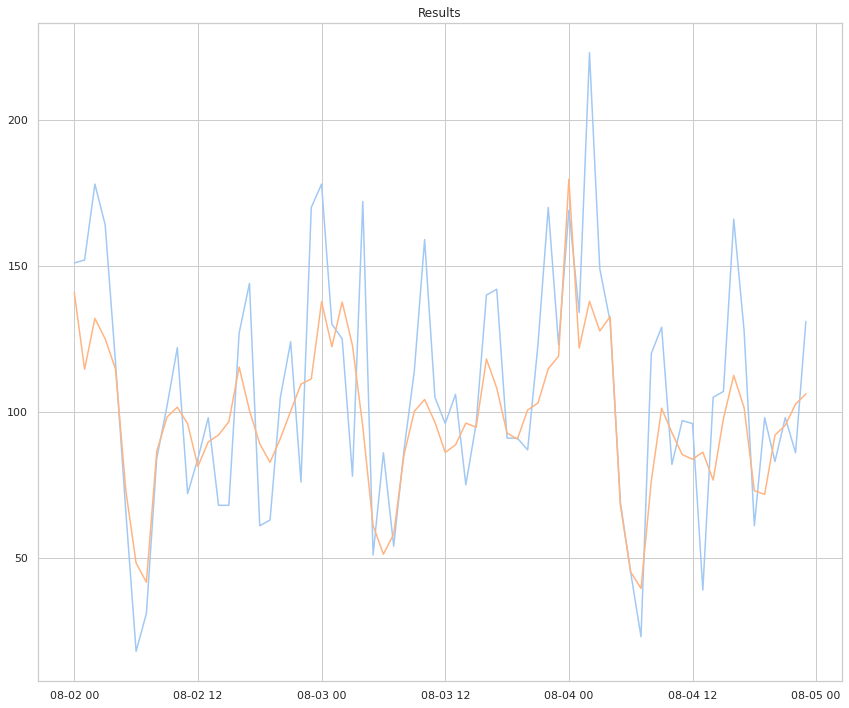

In [82]:
plt.figure(figsize=(12, 10))
plt.plot(
    pd.concat(
        [test_target, pd.DataFrame({'predictions': p_test}, index=test_target.index)], axis=1
             )['2018-08-02':'2018-08-04']
)
plt.title('Results')
plt.tight_layout()

В целом, общая динамика предсказаний совпадает, однако пики не всецело прогнозируются